# Zillow EDA On Missing Values & Multicollinearity
https://www.kaggle.com/viveksrinivasan/zillow-eda-on-missing-values-multicollinearity <br>
start date : 2020-03-27

### The notebook covers Following Topics
- Missing Value Analysis
- Correlation Analysis
- Top Contributing Features (Through XGBoost)
- Correlation Analysis 
- Multicollinearity Analysis
- Univariate Analysis 
- Bivariate Analysis

--------------------------------------------------------
### What I learned
> 1) msno() 함수로 결측치 시각화
* msno.bar() , msno.matrix(), mano.heatmap() <br>

> 2) 히트맵 절반만 나타내기
* np.tril_indices_from 함수 활용
    * mask[np.tril_indices_from(mask)] = False
    
> 3) VIF 구하는 함수 <br>
def calculate_vif_(X): <br>
    variables=list(X.columns)<br>
    vif = {variable:variance_inflation_factor(exog=X.values, exog_idx=ix) for ix,variable in enumerate(list(X.columns))} <br>
    return vif
    
> 4) (for,if문,append 활용)데이터타입이 수치형 이면서 특정 컬럼을 제외한 컬럼만 추출 <br>
numericalCol=[] <br>
for f in merged.columns: <br>
    if merged[f].dtype!='object' and f not in ['parcelid','transactiondate','logerror']: <br>
        numericalCol.append(f)
        
> 5) map,lambda함수 사용해서 년,월,일 분리
* train["year"] = train.transactiondate.map(lambda x: str(x).split("-")[0])

### Global Imports

In [1]:
import pylab
import calendar
import numpy as np
import pandas as pd
import seaborn as sn
color = sn.color_palette()
from scipy import stats
import missingno as msno
from datetime import datetime
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import kendalltau
import warnings
matplotlib.style.use('ggplot')
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore")
%matplotlib inline

### Reading In Dataset

In [2]:
train = pd.read_csv('./data/train_2016_v2.csv', parse_dates=["transactiondate"])
properties = pd.read_csv('./data/properties_2016.csv')

In [3]:
print ("Shape Of Train: ",train.shape)
print ("Shape Of Properties: ",properties.shape)

Shape Of Train:  (90275, 3)
Shape Of Properties:  (2985217, 58)


In [4]:
train.head()

,parcelid,logerror,transactiondate
0,11016594,0.0276,2016-01-01
1,14366692,-0.1684,2016-01-01
2,12098116,-0.0040,2016-01-01
3,12643413,0.0218,2016-01-02
4,14432541,-0.0050,2016-01-02


In [5]:
properties.head()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,10754147,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,9.0,2015.0,9.0,NaN,NaN,NaN,NaN
1,10759547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,27516.0,2015.0,27516.0,NaN,NaN,NaN,NaN
2,10843547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,650756.0,1413387.0,2015.0,762631.0,20800.37,NaN,NaN,NaN
3,10859147,NaN,NaN,NaN,0.0,0.0,3.0,7.0,NaN,NaN,...,1.0,NaN,571346.0,1156834.0,2015.0,585488.0,14557.57,NaN,NaN,NaN
4,10879947,NaN,NaN,NaN,0.0,0.0,4.0,NaN,NaN,NaN,...,NaN,NaN,193796.0,433491.0,2015.0,239695.0,5725.17,NaN,NaN,NaN


### Lets Merge Train And Properties To Facilitate EDA

In [114]:
merged = pd.merge(train,properties,on="parcelid",how="left")

In [7]:
merged.head(3).transpose()

,0,1,2
parcelid,11016594,14366692,12098116
logerror,0.0276,-0.1684,-0.004
transactiondate,2016-01-01 00:00:00,2016-01-01 00:00:00,2016-01-01 00:00:00
airconditioningtypeid,1,NaN,1
architecturalstyletypeid,NaN,NaN,NaN
basementsqft,NaN,NaN,NaN
bathroomcnt,2,3.5,3
bedroomcnt,3,4,2
buildingclasstypeid,NaN,NaN,NaN
buildingqualitytypeid,4,NaN,4


### Visualizing Datatypes

In [77]:
dataTypeDf = pd.DataFrame(merged.dtypes.value_counts()).reset_index().rename(columns={"index":"variableType",0:"count"})
dataTypeDf

,variableType,count
0,float64,53
1,object,5
2,datetime64[ns],1
3,int64,1


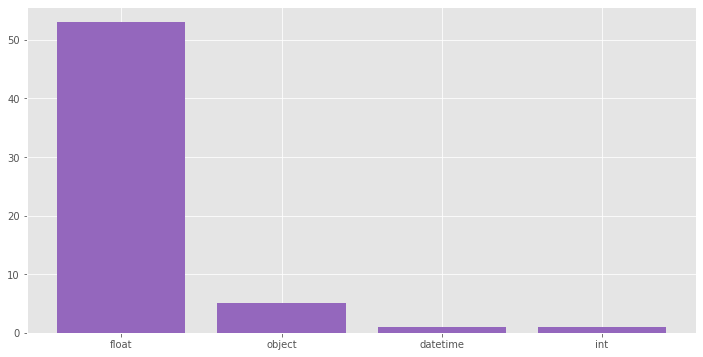

In [73]:
label = ['float', 'object', 'datetime', 'int']
plt.figure(figsize=(12,6))
plt.bar(label, dataTypeDf['count'].values,color=color[4])
plt.show()

### Missing Value Analysis

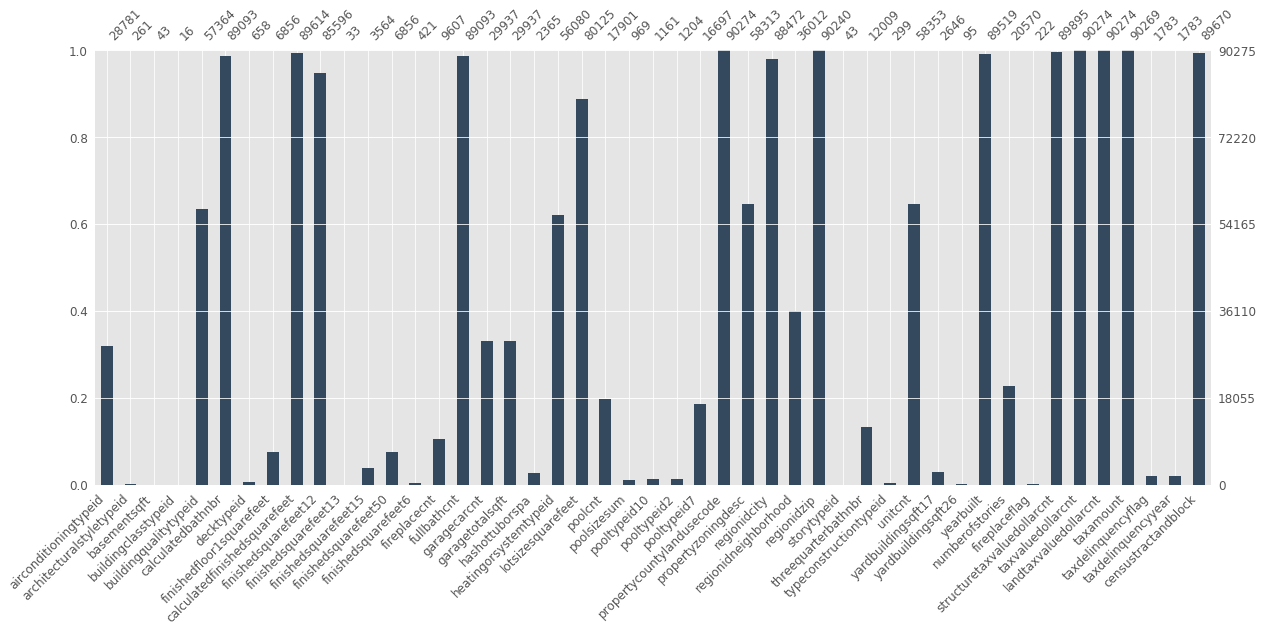

In [87]:
missingValueColumns=merged.columns[merged.isnull().any()].tolist()
msno.bar(merged[missingValueColumns],figsize=(20,8), color="#34495e",fontsize=12,labels=True,)

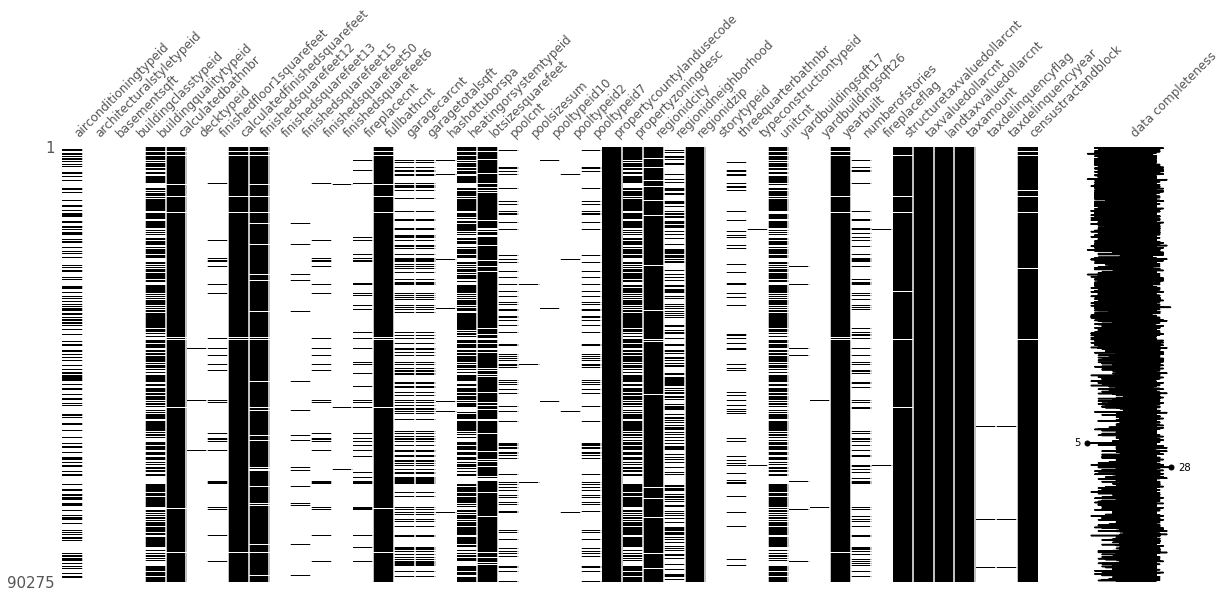

In [88]:
msno.matrix(merged[missingValueColumns],width_ratios=(10,1),figsize=(20,8),color=(0,0,0),fontsize=12, sparkline=True, labels=True)

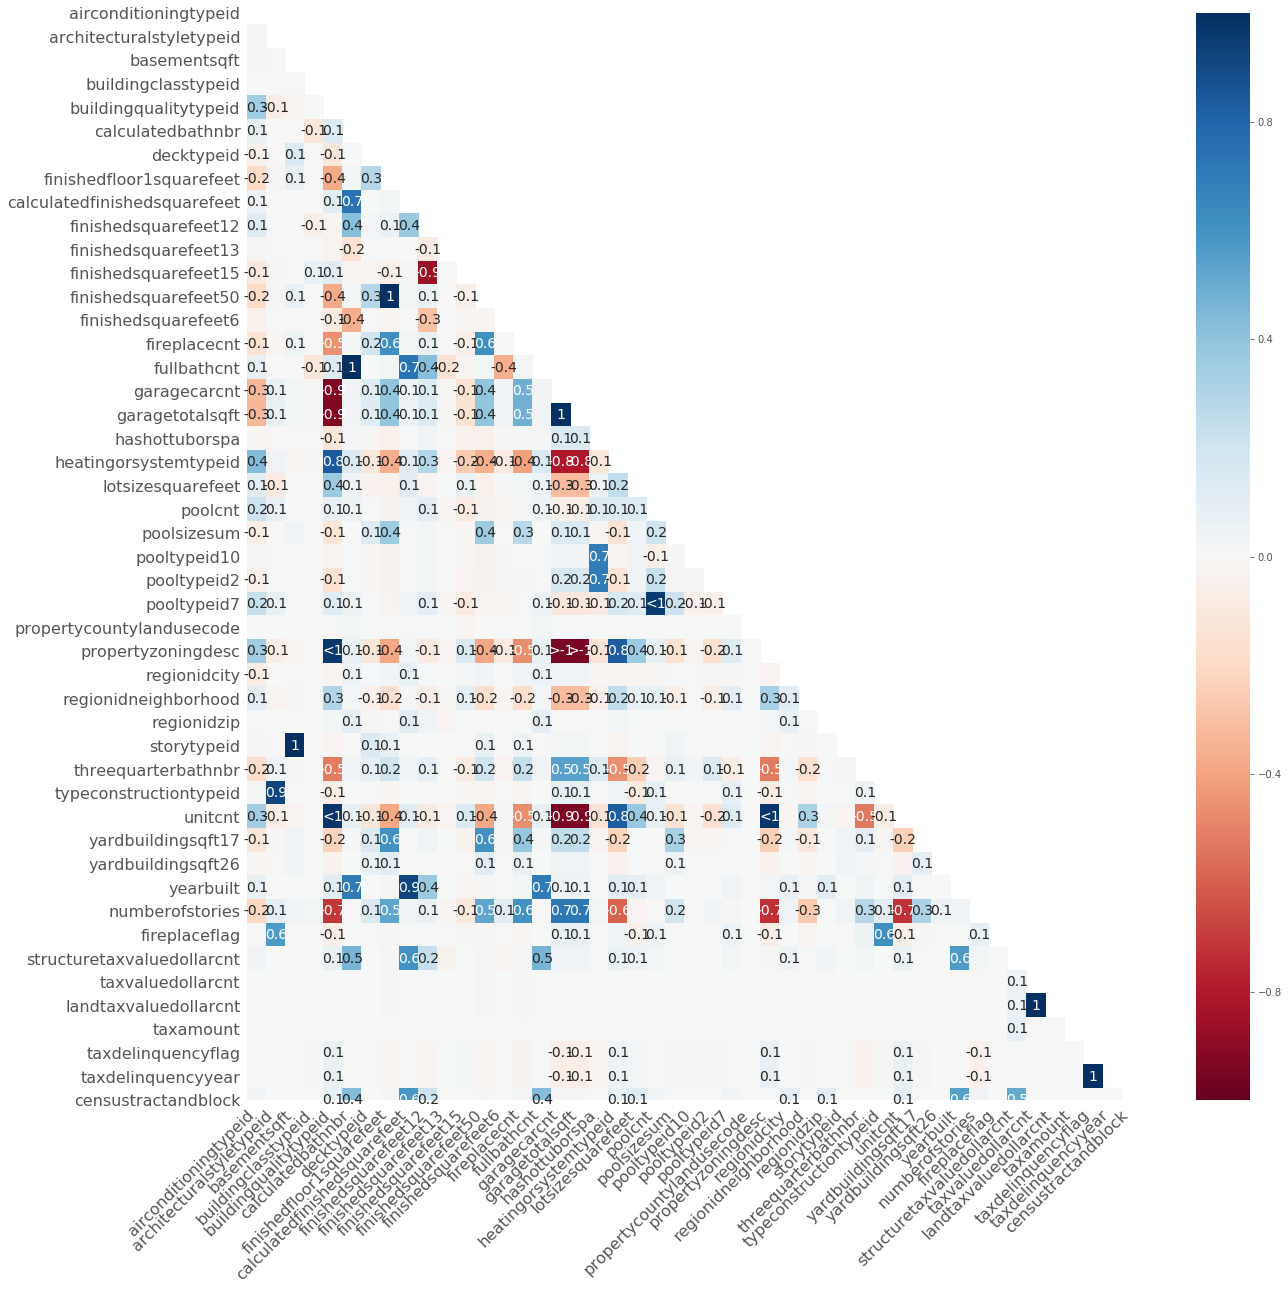

In [89]:
msno.heatmap(merged[missingValueColumns],figsize=(20,20))

### Top Features Selection

In [90]:
from sklearn import model_selection, preprocessing
import xgboost as xgb
import warnings
warnings.filterwarnings("ignore")

In [113]:
mergedFilterd = merged.fillna(-999)
for f in mergedFilterd.columns:
    if mergedFilterd[f].dtype=='object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(mergedFilterd[f].values))
        mergedFilterd[f]=lbl.transform(list(mergedFilterd[f].values))

In [128]:
train_y = mergedFilterd.logerror.values
train_X = mergedFilterd.drop(["parcelid", "transactiondate", "logerror"], axis=1)

xgb_params = {
    'eta': 0.05,
    'max_depth': 8,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}
dtrain = xgb.DMatrix(train_X, train_y, feature_names=train_X.columns.values)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=100)   # num_boost_round= Number of boosting iterations.


[00:20:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


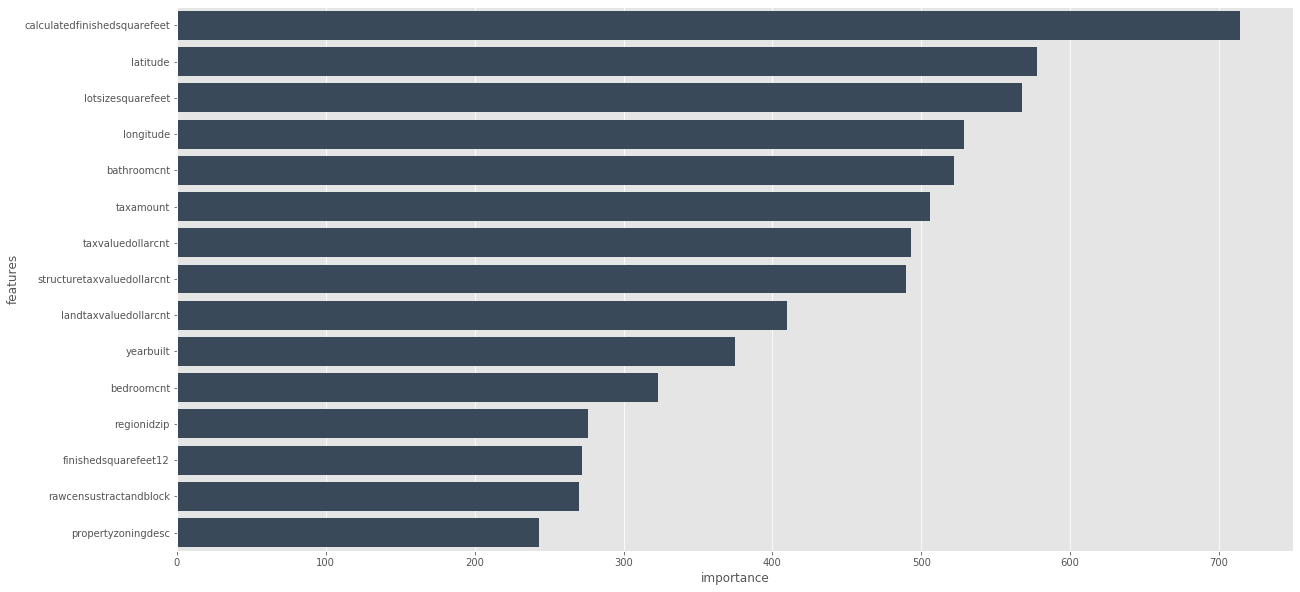

In [146]:
featureImportance=model.get_fscore()
features=pd.DataFrame()
features['features']=featureImportance.keys()
features['importance']=featureImportance.values()
features.sort_values(by=['importance'],ascending=False,inplace=True)
fig,ax=plt.subplots()
fig.set_size_inches(20,10)
#plt.xticks(rotation=90)
sn.barplot(data=features.head(15),x="importance",y='features',ax=ax,orient="h",color="#34495e")

In [149]:
features.head(15)

,features,importance
25,calculatedfinishedsquarefeet,714
24,latitude,578
2,lotsizesquarefeet,568
23,longitude,529
14,bathroomcnt,522
0,taxamount,506
1,taxvaluedollarcnt,493
4,structuretaxvaluedollarcnt,490
19,landtaxvaluedollarcnt,410
3,yearbuilt,375


### Correlation Analysis

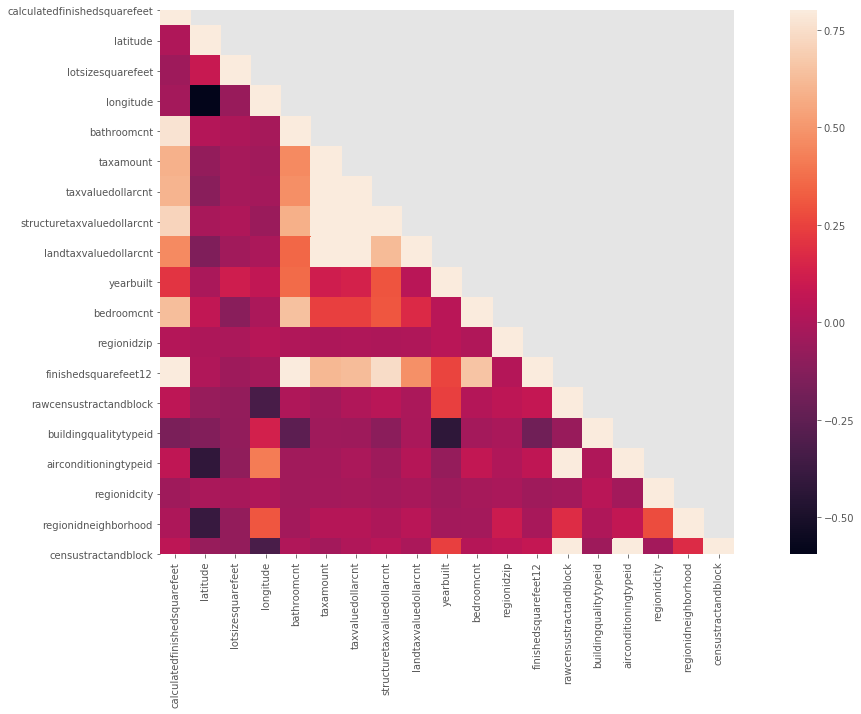

In [171]:
topFeatures = features["features"].tolist()[:20]
corrMatt = merged[topFeatures].corr()
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False

fig,ax= plt.subplots()
fig.set_size_inches(20,10)
sn.heatmap(corrMatt, mask=mask,vmax=.8, square=True)

### Multicollinearity Analysis(다중공선성)
* 다중공선성(multicollinearity): 하나의 독립변수가 다른 여러 개의 독립변수들로 잘 예측되는 경우
* (다중)공선성이 있으면:
    * 계수 추정이 잘 되지 않거나 불안정해져서 데이터가 약간만 바뀌어도 추정치가 크게 달라질 수 있다
    * 계수가 통계적으로 유의미하지 않은 것처럼 나올 수 있다
    
#### 다중공선성의 진단
분산팽창계수(VIF, Variance Inflation Factor)를 구하여 판단 <br>
엄밀한 기준은 없으나 보통 10보다 크면 다중공선성이 있다고 판단(5를 기준으로 하기도 함)

In [172]:
from statsmodels.stats.outliers_influence import variance_inflation_factor  
import warnings
warnings.filterwarnings("ignore")

In [191]:
# 각 컬럼별 VIF를 구하는 함수
def calculate_vif_(X):
    variables=list(X.columns)
    vif = {variable:variance_inflation_factor(exog=X.values, exog_idx=ix) for ix,variable in enumerate(list(X.columns))}
    return vif

In [189]:
# 데이터타입이 수치형인 컬럼만 추출 ('parcelid','transactiondate','logerror' 제외)
numericalCol=[]
for f in merged.columns:
    if merged[f].dtype!='object' and f not in ['parcelid','transactiondate','logerror']:
        numericalCol.append(f)
print(numericalCol)

['airconditioningtypeid', 'architecturalstyletypeid', 'basementsqft', 'bathroomcnt', 'bedroomcnt', 'buildingclasstypeid', 'buildingqualitytypeid', 'calculatedbathnbr', 'decktypeid', 'finishedfloor1squarefeet', 'calculatedfinishedsquarefeet', 'finishedsquarefeet12', 'finishedsquarefeet13', 'finishedsquarefeet15', 'finishedsquarefeet50', 'finishedsquarefeet6', 'fips', 'fireplacecnt', 'fullbathcnt', 'garagecarcnt', 'garagetotalsqft', 'heatingorsystemtypeid', 'latitude', 'longitude', 'lotsizesquarefeet', 'poolcnt', 'poolsizesum', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7', 'propertylandusetypeid', 'rawcensustractandblock', 'regionidcity', 'regionidcounty', 'regionidneighborhood', 'regionidzip', 'roomcnt', 'storytypeid', 'threequarterbathnbr', 'typeconstructiontypeid', 'unitcnt', 'yardbuildingsqft17', 'yardbuildingsqft26', 'yearbuilt', 'numberofstories', 'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'assessmentyear', 'landtaxvaluedollarcnt', 'taxamount', 'taxdelinquencyyear', 'census

In [192]:
# 결측치 -999로채우고, vif 함수적용해서 vif딕셔너리 만들기
mergedFilterd=merged[numericalCol].fillna(-999)
vifDict=calculate_vif_(mergedFilterd)

In [199]:
# vif 데이터프레임으로 만들기
vifDf=pd.DataFrame()
vifDf['variables']=vifDict.keys()
vifDf['vifScore']=vifDict.values()
vifDf.sort_values(by=['vifScore'],ascending=False,inplace=True)
# vif계수를 5 기준으로 데이터분리
validVariables=vifDf[vifDf['vifScore']<=5]
variablesWithMC=vifDf[vifDf["vifScore"]>5]

[Text(0, 0.5, 'Features'),
 Text(0.5, 0, 'VIF Scores'),
 Text(0.5, 1.0, 'Variables Which Exhibit Multicollinearity')]

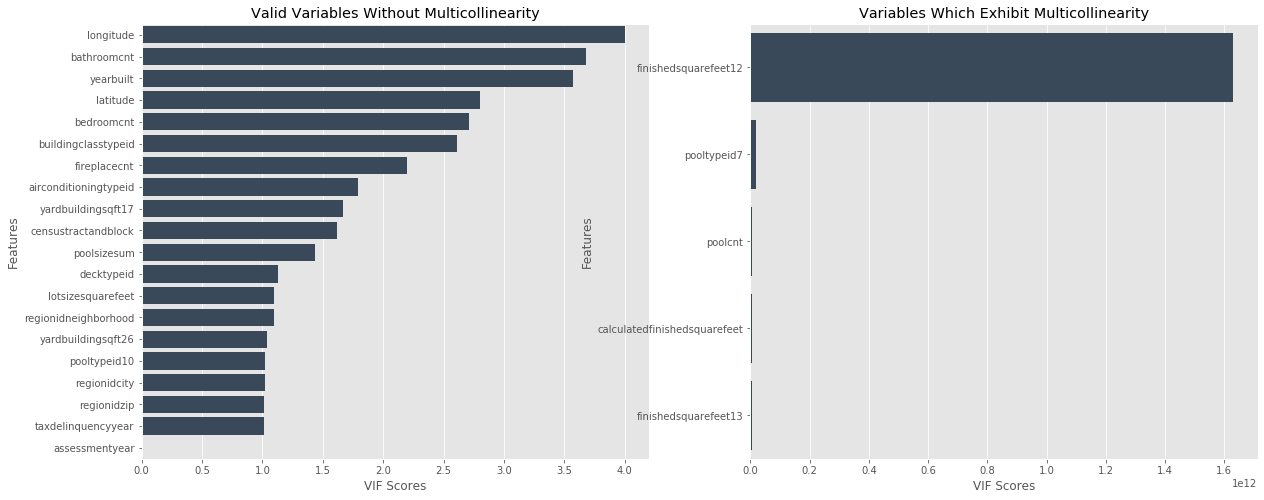

In [203]:
# 시각화
fig,(ax1,ax2) = plt.subplots(ncols=2)
fig.set_size_inches(20,8)
sn.barplot(data=validVariables,x="vifScore",y="variables",ax=ax1,orient="h",color="#34495e")
sn.barplot(data=variablesWithMC.head(5),x="vifScore",y="variables",ax=ax2,orient="h",color="#34495e")
ax1.set(xlabel='VIF Scores', ylabel='Features',title="Valid Variables Without Multicollinearity")
ax2.set(xlabel='VIF Scores', ylabel='Features',title="Variables Which Exhibit Multicollinearity")

### Univariate Analysis
Dependent variable logerror follows nice normal distribution

[Text(0, 0.5, 'VIF Score'),
 Text(0.5, 0, 'logerror'),
 Text(0.5, 1.0, 'Distribution Of Dependent Variable')]

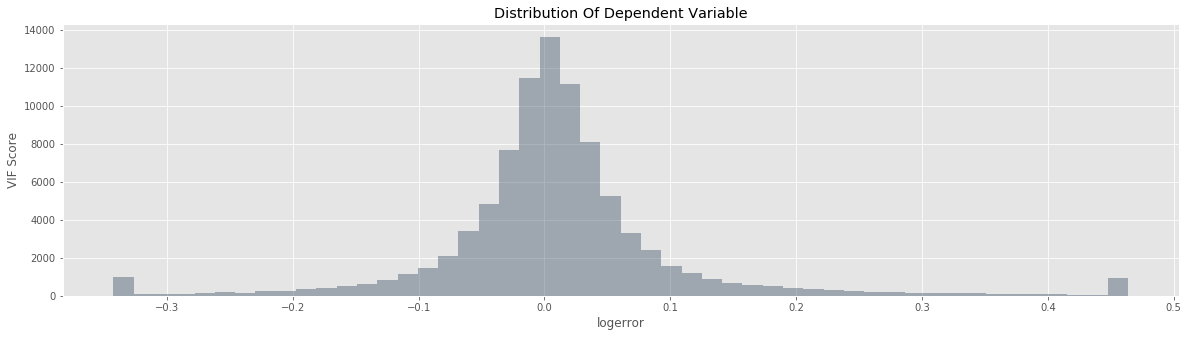

In [212]:
ulimit = np.percentile(merged.logerror.values, 99)
llimit = np.percentile(merged.logerror.values, 1)
merged['logerror'].ix[merged['logerror']>ulimit] = ulimit
merged['logerror'].ix[merged['logerror']<llimit] = llimit

fig,ax = plt.subplots()
fig.set_size_inches(20,5)
sn.distplot(merged.logerror.values, bins=50,kde=False,color="#34495e",ax=ax)
ax.set(xlabel='logerror', ylabel='VIF Score',title="Distribution Of Dependent Variable")

### Bivariate Analysis

In [236]:
train.head()

,parcelid,logerror,transactiondate,year,month,day
0,11016594,0.0276,2016-01-01,2016,01,01
1,14366692,-0.1684,2016-01-01,2016,01,01
2,12098116,-0.0040,2016-01-01,2016,01,01
3,12643413,0.0218,2016-01-02,2016,01,02
4,14432541,-0.0050,2016-01-02,2016,01,02


In [235]:
train["year"] = train.transactiondate.map(lambda x: str(x).split("-")[0])
train["month"] = train.transactiondate.map(lambda x: str(x).split("-")[1])
train["day"] = train.transactiondate.map(lambda x: str(x).split("-")[2].split()[0])

In [246]:
train.groupby(["month"])["logerror"].mean().to_frame().reset_index()

,month,logerror
0,01,0.015870
1,02,0.016082
2,03,0.009867
3,04,0.006605
4,05,0.006926
5,06,0.007172
6,07,0.011687
7,08,0.011573
8,09,0.016255
9,10,0.016342


[Text(0, 0.5, 'No Of Occurences'),
 Text(0.5, 0, 'Month Of The Year'),
 Text(0.5, 1.0, 'No Of Occurunces Across Month In 2016'),
 None]

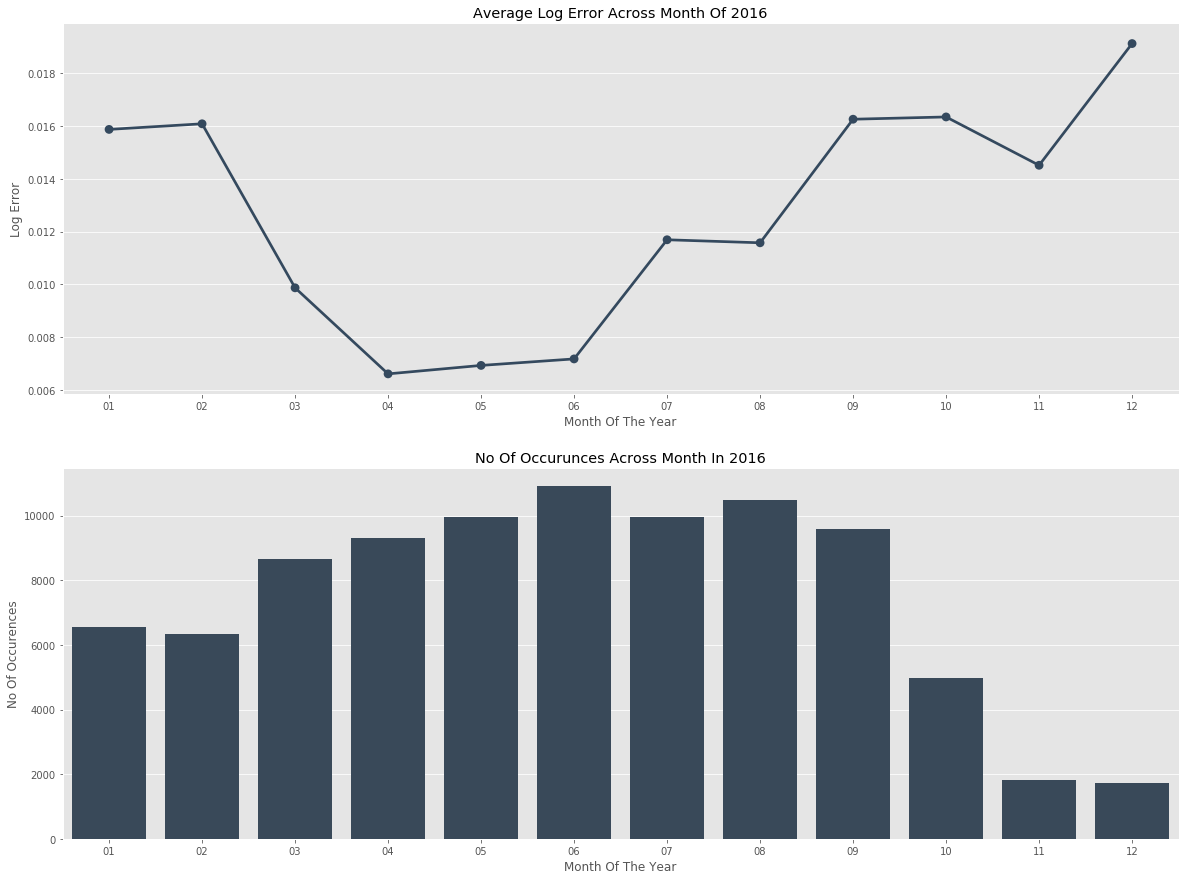

In [247]:
train["year"] = train.transactiondate.map(lambda x: str(x).split("-")[0])
train["month"] = train.transactiondate.map(lambda x: str(x).split("-")[1])
train["day"] = train.transactiondate.map(lambda x: str(x).split("-")[2].split()[0])

traingroupedMonth = train.groupby(["month"])["logerror"].mean().to_frame().reset_index()
traingroupedDay = train.groupby(["day"])["logerror"].mean().to_frame().reset_index()
fig,(ax1,ax2)= plt.subplots(nrows=2)
fig.set_size_inches(20,15)


sn.pointplot(x=traingroupedMonth["month"], y=traingroupedMonth["logerror"], data=traingroupedMonth, join=True,ax=ax1,color="#34495e")
ax1.set(xlabel='Month Of The Year', ylabel='Log Error',title="Average Log Error Across Month Of 2016",label='big')

sn.countplot(x=train["month"], data=train,ax=ax2,color="#34495e")
ax2.set(xlabel='Month Of The Year', ylabel='No Of Occurences',title="No Of Occurunces Across Month In 2016",label='big')

[Text(0, 0.5, 'No Of Occurences'),
 Text(0.5, 0, 'Day Of The Month'),
 Text(0.5, 1.0, 'No Of Occurences Across Days Of The Month In 2016'),
 None]

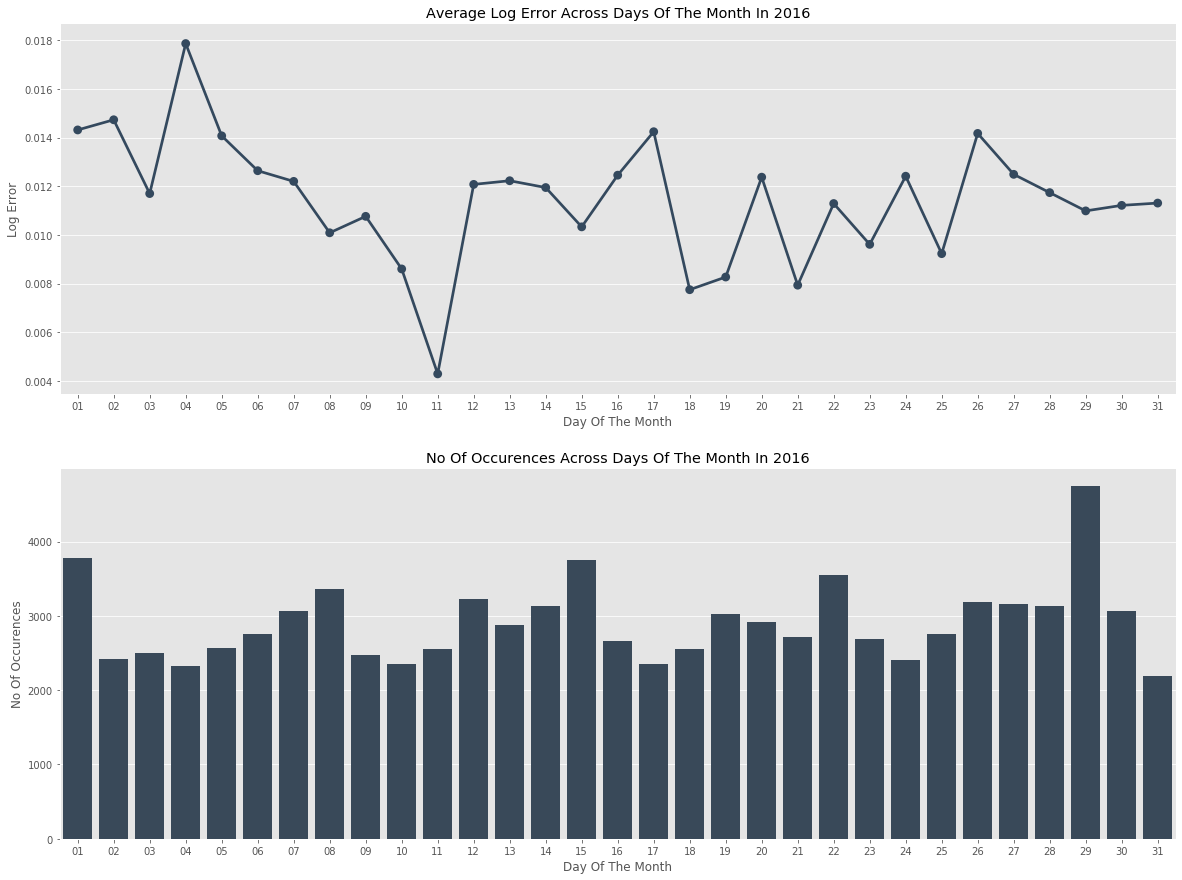

In [248]:
fig,(ax1,ax2)= plt.subplots(nrows=2)
fig.set_size_inches(20,15)

sn.pointplot(x=traingroupedDay["day"], y=traingroupedDay["logerror"], data=traingroupedDay, join=True,ax=ax1,color="#34495e")
ax1.set(xlabel='Day Of The Month', ylabel='Log Error',title="Average Log Error Across Days Of The Month In 2016",label='big')

sn.countplot(x=train["day"], data=train,ax=ax2,color="#34495e")
ax2.set(xlabel='Day Of The Month', ylabel='No Of Occurences',title="No Of Occurences Across Days Of The Month In 2016",label='big')

### No Of Storey Over The Years
It is quite interesting to notice people started building more of 2 or 3 storey buildings After 1950

In [ ]:
fig,ax1= plt.subplots()
fig.set_size_inches(20,10)
merged["yearbuilt"] = merged["yearbuilt"].map(lambda x:str(x).split(".")[0])
yearMerged = merged.groupby(['yearbuilt', 'numberofstories'])["parcelid"].count().unstack('numberofstories').fillna(0)
yearMerged.plot(kind='bar', stacked=True,ax=ax1)